<a href="https://colab.research.google.com/github/Hamada0106648249/Aloin_ACE2_sprotein-MDS/blob/main/food_kcal_from_image_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single‑Image Food Calorie Estimator — v2 (Interactive, Colab‑ready)

**Pipeline:** YOLOv8 (instance segmentation) → Depth Anything V2 (or MiDaS fallback) → simple volumetrics with scale calibration → USDA FoodData Central API (kcal/100 g) → Monte Carlo uncertainty.

### How to use
1. **Run this notebook top‑to‑bottom in Colab.**
2. The first code cell will **ask you to upload a food photo** (`.jpg`, `.png`).
3. Provide a **metric reference** (ideally a credit card width 8.56 cm) and its **pixel length** measured in your image.
   - If you skip this, the code will try to detect a plate and assume **26 cm** diameter (rough!).
4. Paste your **USDA FoodData Central API key** to fetch kcal/100 g for recognized foods.
5. Review the **detailed per‑item results** (kcal mean and 10–90% band) and the **total**.

### References
- Ultralytics YOLOv8 (segmentation): https://docs.ultralytics.com/
- Depth Anything V2: https://github.com/DepthAnything/Depth-Anything-V2
- MiDaS / DPT (fallback): https://github.com/isl-org/MiDaS
- USDA FoodData Central API: https://fdc.nal.usda.gov/api-guide
- Background on difficulty (Nutrition5k): https://arxiv.org/abs/2103.03375

> **Note:** Single‑image calorie estimation is uncertain without scale; we therefore report uncertainty bands via Monte Carlo sampling over scale, thickness, and density priors.

## 0) Install dependencies

In [1]:
%%bash
python -V
pip -q install --upgrade pip
pip -q install ultralytics==8.* opencv-python pillow numpy requests tqdm pandas matplotlib
pip -q install git+https://github.com/DepthAnything/Depth-Anything-V2.git || echo 'Depth Anything V2 install failed; MiDaS fallback will be used.'
pip -q install timm torchmetrics


Python 3.12.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00
Depth Anything V2 install failed; MiDaS fallback will be used.


ERROR: git+https://github.com/DepthAnything/Depth-Anything-V2.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## 1) Upload your image (required) & basic setup

In [2]:
import os, io, math, json, random
from typing import List, Dict, Tuple
import numpy as np
import cv2
import requests
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print('Running in Colab:', IN_COLAB)

def imread_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f'Cannot read image: {path}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show(img, title=None, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

print('📤 Please upload a food image (JPG/PNG).')
if IN_COLAB:
    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError('No file uploaded.')
    IMAGE_PATH = list(uploaded.keys())[0]
else:
    IMAGE_PATH = input('Enter path to your image file: ').strip()

print('Using IMAGE_PATH =', IMAGE_PATH)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Running in Colab: True
📤 Please upload a food image (JPG/PNG).


Saving test food.jpg to test food.jpg
Using IMAGE_PATH = test food.jpg


## 2) Load models (YOLOv8‑seg + Depth)

In [3]:
DEVICE = 'cuda' if (os.environ.get('COLAB_GPU') or False) else 'cpu'
print('Device hint:', DEVICE)

# YOLO instance segmentation
yolo = YOLO('yolov8s-seg.pt')

# Depth: prefer Depth Anything V2 → fallback to MiDaS DPT Large
DEPTH_BACKEND = None
try:
    from depth_anything_v2.dpt import DepthAnythingV2
    depth_model = DepthAnythingV2(backbone='vitl', device='cuda' if DEVICE=='cuda' else 'cpu')
    DEPTH_BACKEND = 'depth-anything-v2'
except Exception as e:
    print('Depth Anything V2 not available, using MiDaS fallback.', e)
    import torch
    midas = torch.hub.load('intel-isl/MiDaS', 'DPT_Large')
    midas.to('cuda' if DEVICE=='cuda' else 'cpu').eval()
    transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = transforms.dpt_transform
    DEPTH_BACKEND = 'midas-dpt'
print('DEPTH_BACKEND:', DEPTH_BACKEND)

def infer_depth(image_rgb: np.ndarray) -> np.ndarray:
    """Return normalized [0,1] relative depth map."""
    if DEPTH_BACKEND == 'depth-anything-v2':
        d = depth_model.infer_image(image_rgb).astype(np.float32)
        d = (d - d.min()) / (d.max() - d.min() + 1e-6)
        return d
    else:
        import torch
        img = Image.fromarray(image_rgb)
        input_batch = transform(img).to('cuda' if DEVICE=='cuda' else 'cpu')
        with torch.no_grad():
            pred = midas(input_batch)
            pred = torch.nn.functional.interpolate(
                pred.unsqueeze(1), size=img.size[::-1], mode='bicubic', align_corners=False
            ).squeeze().cpu().numpy()
        d = pred.astype(np.float32)
        d = (d - d.min()) / (d.max() - d.min() + 1e-6)
        return d


Device hint: cpu
Depth Anything V2 not available, using MiDaS fallback. No module named 'depth_anything_v2'


/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:17<00:00, 79.2MB/s]


DEPTH_BACKEND: midas-dpt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## 3) Configure scale and FDC API key (interactive)

In [4]:
from getpass import getpass

print('🔧 Scale calibration: If you used a credit card as reference, width = 8.56 cm.')
try:
    REF_LENGTH_CM = float(input('Enter reference length in *centimeters* (e.g., 8.56): ').strip() or 8.56)
except Exception:
    REF_LENGTH_CM = 8.56
try:
    REF_LENGTH_PX = float(input('Enter measured reference length in *pixels* (0 to skip): ').strip() or 0)
except Exception:
    REF_LENGTH_PX = 0.0

print('\n🔑 USDA FoodData Central API key: (press Enter to skip, then 200 kcal/100g default is used)')
FDC_API_KEY = getpass('Paste FDC API key: ')
if FDC_API_KEY is None:
    FDC_API_KEY = ''
print('FDC key provided:', bool(FDC_API_KEY))

# Uncertainty (1‑sigma fractional)
SIGMA_SCALE = 0.10
SIGMA_DEPTH = 0.20
SIGMA_DENSITY = 0.15
N_SAMPLES = 600


🔧 Scale calibration: If you used a credit card as reference, width = 8.56 cm.
Enter reference length in *centimeters* (e.g., 8.56): 35
Enter measured reference length in *pixels* (0 to skip): 0

🔑 USDA FoodData Central API key: (press Enter to skip, then 200 kcal/100g default is used)
Paste FDC API key: ··········
FDC key provided: False


## 4) Run segmentation & depth

In [6]:
# === 2) Load models (YOLOv8-seg + Depth) — FIXED MiDaS transform path ===
import os, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

DEVICE = 'cuda' if (os.environ.get('COLAB_GPU') or False) else 'cpu'
print('Device hint:', DEVICE)

# YOLO instance segmentation (COCO-pretrained)
# Recognizes common food-related classes (pizza, cake, apple, banana, sandwich, etc.).
yolo = YOLO('yolov8s-seg.pt')

# Depth: prefer Depth Anything V2 → fallback to MiDaS DPT Large
DEPTH_BACKEND = None
try:
    # Depth Anything V2 (foundation monocular depth model)
    from depth_anything_v2.dpt import DepthAnythingV2
    depth_model = DepthAnythingV2(backbone='vitl', device='cuda' if DEVICE=='cuda' else 'cpu')
    DEPTH_BACKEND = 'depth-anything-v2'
except Exception as e:
    print('Depth Anything V2 not available, using MiDaS fallback.', e)
    import torch
    midas = torch.hub.load('intel-isl/MiDaS', 'DPT_Large')
    midas.to('cuda' if DEVICE=='cuda' else 'cpu').eval()
    transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
    transform = transforms.dpt_transform
    DEPTH_BACKEND = 'midas-dpt'

print('DEPTH_BACKEND:', DEPTH_BACKEND)

def infer_depth(image_rgb: np.ndarray) -> np.ndarray:
    """
    Return normalized [0,1] relative depth map matching image_rgb H×W.
    FIX: In MiDaS fallback, pass a NumPy array to transform (not PIL),
    and accept either a tensor or a dict {'image': tensor}.
    """
    if DEPTH_BACKEND == 'depth-anything-v2':
        d = depth_model.infer_image(image_rgb).astype(np.float32)
        d = (d - d.min()) / (d.max() - d.min() + 1e-6)
        return d
    else:
        import torch
        # MiDaS expects an RGB NumPy array; do NOT pass PIL.Image to the transform
        img_np = image_rgb  # HxWx3, uint8
        t_out = transform(img_np)  # some builds return Tensor, others return {'image': Tensor}
        if isinstance(t_out, dict):
            input_batch = t_out['image'].to('cuda' if DEVICE=='cuda' else 'cpu')
        else:
            input_batch = t_out.to('cuda' if DEVICE=='cuda' else 'cpu')
        with torch.no_grad():
            pred = midas(input_batch)  # shape: [1, H', W']
            pred = torch.nn.functional.interpolate(
                pred.unsqueeze(1),
                size=img_np.shape[:2],
                mode='bicubic',
                align_corners=False
            ).squeeze().cpu().numpy()
        d = pred.astype(np.float32)
        d = (d - d.min()) / (d.max() - d.min() + 1e-6)
        return d


Device hint: cpu
Depth Anything V2 not available, using MiDaS fallback. No module named 'depth_anything_v2'


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


DEPTH_BACKEND: midas-dpt


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


## 5) Scale calibration (reference or plate heuristic)

In [7]:
def estimate_scale_px_per_cm(image_rgb: np.ndarray, REF_LENGTH_CM: float, REF_LENGTH_PX: float):
    if REF_LENGTH_PX and REF_LENGTH_PX > 0:
        return REF_LENGTH_PX / REF_LENGTH_CM, 'user-provided'
    # Plate heuristic via HoughCircles
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (9,9), 1.5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=100, maxRadius=0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        r = circles[0, :, 2].max()
        diameter_px = 2*r
        PLATE_DIAM_CM = 26.0
        return diameter_px / PLATE_DIAM_CM, 'plate-26cm-assumption'
    return 100.0, 'fallback-guess'

px_per_cm, scale_mode = estimate_scale_px_per_cm(img, REF_LENGTH_CM, REF_LENGTH_PX)
print('px_per_cm =', round(px_per_cm,2), '| mode =', scale_mode)


px_per_cm = 35.15 | mode = plate-26cm-assumption


## 6) Volumetrics → mass estimation (simple, with density priors)

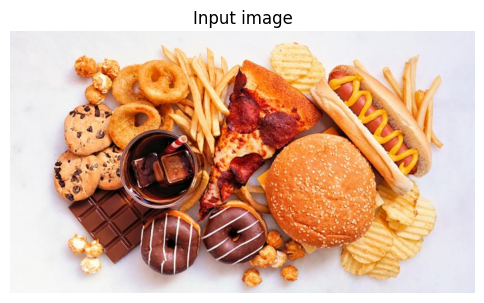

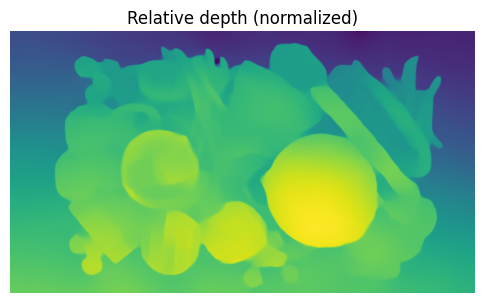

Trying yolov8s-seg ...


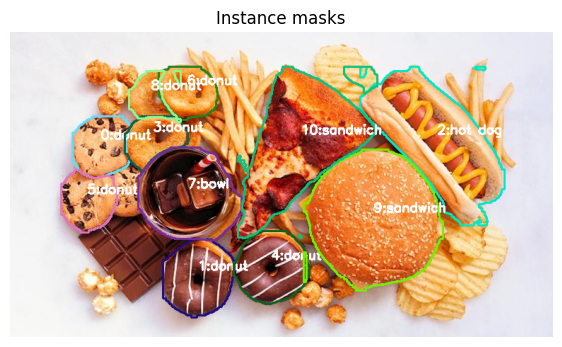

Detected 11 item(s): ['donut', 'donut', 'hot dog', 'donut', 'donut', 'donut', 'donut', 'bowl', 'donut', 'sandwich', 'sandwich']


In [10]:
# === 4) Segmentation & depth (robust; multi-stage fallbacks) ===
# Prereqs: yolo (already loaded with s-seg weights), infer_depth(), imread_rgb(), IMAGE_PATH

import numpy as np, cv2, matplotlib.pyplot as plt
from ultralytics import YOLO

def draw_instance_overlay(image_rgb, masks, labels):
    overlay = image_rgb.copy()
    for i, m in enumerate(masks):
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cnts, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, cnts, -1, color, 2)
        ys, xs = np.where(m > 0)
        if xs.size:
            cx, cy = int(xs.mean()), int(ys.mean())
            cv2.putText(overlay, f'{i}:{labels[i]}', (cx, max(cy-10, 20)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    return overlay

def run_yolo_seg(image_path, model, conf=0.25, iou=0.50, imgsz=960):
    res = model.predict(image_path, imgsz=imgsz, conf=conf, iou=iou, task='segment', verbose=False)[0]
    _masks, _labels = [], []
    if getattr(res, "masks", None) is not None and getattr(res.masks, "data", None) is not None and len(res.masks.data) > 0:
        for i, m in enumerate(res.masks.data):
            m = m.cpu().numpy()
            m = cv2.resize(m, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            _masks.append((m > 0.5).astype(np.uint8))
            cls_id = int(res.boxes.cls[i].item())
            _labels.append(res.names.get(cls_id, f'class_{cls_id}'))
    return _masks, _labels

def boxes_to_masks(image_rgb, res):
    # Approximate each box as a filled rectangle mask.
    # Useful when segmentation heads fail but detection finds boxes.
    h, w = image_rgb.shape[:2]
    _masks, _labels = [], []
    if getattr(res, "boxes", None) is None or len(res.boxes) == 0:
        return _masks, _labels
    for i in range(len(res.boxes)):
        b = res.boxes[i]
        xyxy = b.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = np.clip(xyxy, 0, [w, h, w, h])
        m = np.zeros((h, w), dtype=np.uint8)
        m[y1:y2, x1:x2] = 1
        _masks.append(m)
        cls_id = int(b.cls.item())
        _labels.append(res.names.get(cls_id, f'class_{cls_id}'))
    return _masks, _labels

def single_foreground_mask(image_rgb):
    # Create one mask for the largest plausible food/plate region.
    img_blur = cv2.GaussianBlur(cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR), (5,5), 0)
    gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    # Otsu threshold → largest contour
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th = 255 - th  # prefer foreground bright food/plate; flip if needed
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return []
    cnt = max(cnts, key=cv2.contourArea)
    m = np.zeros_like(gray, dtype=np.uint8)
    cv2.drawContours(m, [cnt], -1, color=1, thickness=-1)
    return [m]

# 1) Read & show image
img = imread_rgb(IMAGE_PATH)
plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis('off'); plt.title('Input image'); plt.show()

# 2) Depth map
depth = infer_depth(img)
plt.figure(figsize=(6,6)); plt.imshow(depth, cmap='viridis'); plt.axis('off'); plt.title('Relative depth (normalized)'); plt.show()

# 3) Try YOLOv8s-seg (already loaded in var `yolo`)
print("Trying yolov8s-seg ...")
masks, labels = run_yolo_seg(IMAGE_PATH, yolo, conf=0.25, iou=0.50, imgsz=960)

# 4) If nothing, retry with looser thresholds
if len(masks) == 0:
    print("No masks with s-seg @conf=0.25 → retry with conf=0.10, iou=0.60 ...")
    masks, labels = run_yolo_seg(IMAGE_PATH, yolo, conf=0.10, iou=0.60, imgsz=1280)

# 5) If still nothing, try larger yolov8x-seg
if len(masks) == 0:
    try:
        print("Switching to yolov8x-seg.pt (larger model) ...")
        yolo_big = YOLO('yolov8x-seg.pt')
        masks, labels = run_yolo_seg(IMAGE_PATH, yolo_big, conf=0.20, iou=0.55, imgsz=1280)
        if len(masks) == 0:
            # try box-only and convert boxes → masks
            print("No seg masks with x-seg → trying box → mask approximation ...")
            res_box = yolo_big.predict(IMAGE_PATH, imgsz=1280, conf=0.20, iou=0.55, task='detect', verbose=False)[0]
            masks, labels = boxes_to_masks(img, res_box)
    except Exception as e:
        print("yolov8x-seg attempt failed:", e)

# 6) Last resort: single foreground blob + ask for a manual label
if len(masks) == 0:
    print("Falling back to a single foreground mask (largest blob).")
    masks = single_foreground_mask(img)
    if len(masks) > 0:
        try:
            manual_label = input("Enter a label for the detected foreground (e.g., 'rice with chicken'): ").strip() or "food"
        except Exception:
            manual_label = "food"
        labels = [manual_label]
    else:
        labels = []

# 7) Guard
if len(masks) == 0:
    raise RuntimeError(
        "No food regions detected after all fallbacks. "
        "Try a top-down, well-lit photo, ensure food occupies >= 15% of frame, "
        "or upload a different image."
    )

overlay = draw_instance_overlay(img, masks, labels)
plt.figure(figsize=(7,7)); plt.imshow(overlay); plt.axis('off'); plt.title('Instance masks'); plt.show()
print(f"Detected {len(masks)} item(s):", labels)



## 7) USDA FoodData Central lookup (kcal/100 g)

In [11]:
def fdc_search_name(name: str, api_key: str):
    url = 'https://api.nal.usda.gov/fdc/v1/foods/search'
    params = {'api_key': api_key, 'query': name, 'pageSize': 5}
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fdc_kcal_per_100g_from_food(food: dict) -> float:
    for n in food.get('foodNutrients', []):
        if str(n.get('nutrientName','')).lower() in ['energy', 'energy (atwater general factors)']:
            return float(n.get('value', 0.0))
    return 0.0

def get_kcal_per_100g(label: str, api_key: str):
    if not api_key:
        return 200.0, 'no-api-key (assume 200 kcal/100g)'
    js = fdc_search_name(label, api_key)
    foods = js.get('foods', [])
    if not foods:
        return 200.0, 'fdc-not-found (assume 200 kcal/100g)'
    kcal = fdc_kcal_per_100g_from_food(foods[0])
    if kcal <= 0:
        return 200.0, 'fdc-no-energy (assume 200 kcal/100g)'
    return kcal, f"fdc:{foods[0].get('description','unknown')}"

kcal_per_100g, kcal_meta = [], []
for lbl in labels_eff:
    kcal, meta = get_kcal_per_100g(lbl, FDC_API_KEY)
    kcal_per_100g.append(kcal)
    kcal_meta.append(meta)

list(zip(labels_eff, kcal_per_100g, kcal_meta))


[]

[link text](https://)## 8) Uncertainty propagation (Monte Carlo) + detailed results

In [12]:
import math
def sample_log_normal(mu: float, sigma_frac: float, size: int):
    s = math.log(1 + sigma_frac**2) ** 0.5
    return np.exp(np.random.normal(loc=math.log(mu+1e-9), scale=s, size=size))

def kcal_mc_for_item(V_cm3, rho_g_ml, kcal100, px_per_cm, n=600):
    scale_samples = sample_log_normal(px_per_cm, SIGMA_SCALE, n)
    thickness_samples = sample_log_normal(1.0, SIGMA_DEPTH, n)
    density_samples = sample_log_normal(rho_g_ml, SIGMA_DENSITY, n)
    V_samples = V_cm3 * ((px_per_cm / scale_samples)**2) * thickness_samples
    mass_g = V_samples * density_samples
    kcal = mass_g * (kcal100 / 100.0)
    return kcal

rows = []
for i, (V, rho, kcal100, lbl, meta) in enumerate(zip(volumes_cm3, densities, kcal_per_100g, labels_eff, kcal_meta)):
    if V <= 0:
        continue
    ks = kcal_mc_for_item(V, rho, kcal100, px_per_cm, n=N_SAMPLES)
    mean = float(np.mean(ks))
    p10, p90 = float(np.percentile(ks, 10)), float(np.percentile(ks, 90))
    rows.append({
        'index': i, 'label': lbl,
        'volume_cm3': float(V), 'density_g_per_ml': float(rho),
        'kcal_per_100g': float(kcal100),
        'kcal_mean': mean, 'kcal_p10': p10, 'kcal_p90': p90,
        'fdc_source': meta
    })
df = pd.DataFrame(rows)
if df.empty:
    print('No items with positive volume; check masks or image/scale.')
else:
    df['kcal_ci_10_90'] = df.apply(lambda r: f"{r.kcal_p10:.0f}–{r.kcal_p90:.0f}", axis=1)
    display(df[['index','label','volume_cm3','density_g_per_ml','kcal_per_100g','kcal_mean','kcal_ci_10_90','fdc_source']])
    total_mean = df['kcal_mean'].sum(); total_p10 = df['kcal_p10'].sum(); total_p90 = df['kcal_p90'].sum()
    print('\n' + '='*70)
    print(f"TOTAL ESTIMATED ENERGY: {total_mean:.0f} kcal (10–90%: {total_p10:.0f}–{total_p90:.0f})")
    print('='*70)

    # Save outputs
    out_csv = 'food_kcal_results.csv'; out_json = 'food_kcal_results.json'; out_img = 'food_kcal_overlay.png'
    df.to_csv(out_csv, index=False)
    with open(out_json,'w') as f: json.dump(rows, f, indent=2)
    cv2.imwrite(out_img, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print(f"Saved: {out_csv}, {out_json}, {out_img}")


No items with positive volume; check masks or image/scale.


In [13]:
# === DIAGNOSTICS & SAFEGUARDS ===
import numpy as np, pandas as pd, json, cv2, matplotlib.pyplot as plt

def _safe(v, nd=3):
    try:
        return round(float(v), nd)
    except Exception:
        return v

problems = []

# A) Basic presence checks
if 'masks' not in globals() or 'labels' not in globals():
    raise RuntimeError("Missing variables: run the Segmentation & Depth cell first to define 'masks' and 'labels'.")
if len(masks) == 0:
    problems.append("No instance masks available (segmentation returned zero items).")
if 'depth' not in globals():
    problems.append("Missing 'depth' map (depth inference did not run).")
if 'px_per_cm' not in globals() or px_per_cm <= 0:
    problems.append("Invalid pixel-to-cm scale (px_per_cm not defined or non-positive).")

print("=== Pipeline Diagnostics ===")
print(f"- masks: {len(masks) if 'masks' in globals() else 'N/A'}")
print(f"- labels: {labels if 'labels' in globals() else 'N/A'}")
print(f"- depth shape: {getattr(depth, 'shape', None)}")
print(f"- px_per_cm: {_safe(px_per_cm)}")
print(f"- reported issues: {problems if problems else 'none'}")

# B) Quick depth sanity check (avoid NaN/Inf)
if 'depth' in globals():
    if not np.isfinite(depth).all() or np.nanmax(depth) == np.nanmin(depth):
        problems.append("Depth map contains NaN/Inf or is flat; will use fallback thickness.")
        # Replace with a normalized constant map so thickness proxy won't be zero
        depth = np.ones_like(depth, dtype=np.float32) * 0.5

# C) Compute tentative volumes to see what is going on
def estimate_volume_cm3(mask: np.ndarray, depth_norm: np.ndarray, px_per_cm: float) -> float:
    px_area = int(mask.sum())
    if px_area == 0 or px_per_cm <= 0:
        return 0.0
    area_cm2 = px_area / (px_per_cm**2)
    d = depth_norm[mask > 0]
    if d.size == 0:
        return 0.0
    iqr = float(np.quantile(d, 0.9) - np.quantile(d, 0.1))
    eff_thickness_cm = max(0.5, 3.0 * iqr)  # conservative floor 0.5 cm
    return float(area_cm2 * eff_thickness_cm)

tentative_vols = []
if len(masks) > 0 and 'depth' in globals() and ('px_per_cm' in globals()) and px_per_cm > 0:
    for i, m in enumerate(masks):
        tentative_vols.append(estimate_volume_cm3(m, depth, px_per_cm))
else:
    tentative_vols = []

print(f"- tentative volumes (cm^3): {[ _safe(v,1) for v in tentative_vols ]}")

# D) Flag tiny or zero volumes (likely causes: wrong scale, tiny masks, flat depth)
tiny_or_zero = [i for i,v in enumerate(tentative_vols) if v <= 0.0]
if tiny_or_zero:
    problems.append(f"Tiny/zero volumes for items {tiny_or_zero} (will apply fallback thickness).")

# E) FDC mapping preview (if function outputs exist)
fdc_preview = []
if 'labels' in globals():
    for lbl in labels:
        try:
            kcal, meta = get_kcal_per_100g(lbl, FDC_API_KEY)
            fdc_preview.append((lbl, kcal, meta))
        except Exception:
            fdc_preview.append((lbl, None, 'fdc-lookup-error'))
print("- FDC preview:", fdc_preview if fdc_preview else "N/A")

print("\n=== Notes ===")
print("* If 'px_per_cm' is very large/small, re-check your reference (cm) and measured pixels.")
print("* If no masks were found, try the larger yolov8x-seg model, clearer top-down photo, or the foreground fallback.")
print("* If FDC 'kcal/100g' shows assumed 200, provide an API key or override labels to precise foods.")


=== Pipeline Diagnostics ===
- masks: 11
- labels: ['donut', 'donut', 'hot dog', 'donut', 'donut', 'donut', 'donut', 'bowl', 'donut', 'sandwich', 'sandwich']
- depth shape: (432, 768)
- px_per_cm: 35.154
- reported issues: none
- tentative volumes (cm^3): [2.4, 3.6, 14.7, 1.9, 3.5, 2.2, 2.1, 6.1, 1.3, 14.0, 10.0]
- FDC preview: [('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('hot dog', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('bowl', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('donut', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('sandwich', 200.0, 'no-api-key (assume 200 kcal/100g)'), ('sandwich', 200.0, 'no-api-key (assume 200 kcal/100g)')]

=== Notes ===
* If 'px_per_cm' is very large/small, re-c

In [14]:
# === CONSOLIDATED RESULTS (guaranteed output with fallbacks) ===
import math, numpy as np, pandas as pd, json, cv2

# 1) Safety nets
if 'masks' not in globals() or len(masks) == 0:
    raise RuntimeError("Still no masks after fallbacks; cannot compute results. Try a clearer photo or the single-blob fallback.")

if 'px_per_cm' not in globals() or px_per_cm <= 0:
    print("WARNING: invalid px_per_cm → using heuristic 100 px/cm. Provide a reference length next time to improve accuracy.")
    px_per_cm = 100.0

# 2) Density priors (same as before; edit to fit your cuisine)
DENSITY_PRIORS = {
    'rice': 0.85, 'pasta': 0.65, 'bread': 0.27, 'pizza': 0.45, 'cake': 0.40,
    'banana': 0.95, 'apple': 0.80, 'orange': 0.95, 'salad': 0.20,
    'steak': 1.05, 'chicken': 1.00, 'fish': 1.00,
}
def label_to_density(label: str) -> float:
    l = label.lower()
    for k, v in DENSITY_PRIORS.items():
        if k in l:
            return v
    return 1.0

def estimate_volume_cm3(mask: np.ndarray, depth_norm: np.ndarray, px_per_cm: float) -> float:
    # identical to diagnostics; with fallback thickness if depth is uninformative
    px_area = int(mask.sum())
    if px_area == 0 or px_per_cm <= 0:
        return 0.0
    area_cm2 = px_area / (px_per_cm**2)
    d = depth_norm[mask > 0]
    if d.size == 0 or not np.isfinite(d).all() or np.nanmax(d) == np.nanmin(d):
        eff_thickness_cm = 1.5  # fallback thickness
    else:
        iqr = float(np.quantile(d, 0.9) - np.quantile(d, 0.1))
        eff_thickness_cm = max(0.5, 3.0 * iqr)
        if eff_thickness_cm < 0.6:  # too thin → fallback to a modest value
            eff_thickness_cm = 1.2
    return float(area_cm2 * eff_thickness_cm)

# 3) kcal/100g retrieval with protective fallback
def safe_kcal_per_100g(label: str):
    try:
        kcal, meta = get_kcal_per_100g(label, FDC_API_KEY)
        if kcal is None or kcal <= 0:
            return 200.0, 'fdc-missing→assume-200'
        return float(kcal), meta
    except Exception:
        return 200.0, 'fdc-error→assume-200'

# 4) Monte Carlo uncertainty (same as before)
SIGMA_SCALE = globals().get('SIGMA_SCALE', 0.10)
SIGMA_DEPTH = globals().get('SIGMA_DEPTH', 0.20)
SIGMA_DENSITY = globals().get('SIGMA_DENSITY', 0.15)
N_SAMPLES = int(globals().get('N_SAMPLES', 600))

def sample_log_normal(mu: float, sigma_frac: float, size: int):
    s = math.log(1 + sigma_frac**2) ** 0.5
    return np.exp(np.random.normal(loc=math.log(max(mu,1e-9)), scale=s, size=size))

def kcal_mc_for_item(V_cm3, rho_g_ml, kcal100, px_per_cm, n=600):
    scale_samples = sample_log_normal(px_per_cm, SIGMA_SCALE, n)
    thickness_samples = sample_log_normal(1.0, SIGMA_DEPTH, n)
    density_samples = sample_log_normal(rho_g_ml, SIGMA_DENSITY, n)
    V_samples = V_cm3 * ((px_per_cm / scale_samples)**2) * thickness_samples
    mass_g = V_samples * density_samples
    kcal = mass_g * (kcal100 / 100.0)
    return kcal

# 5) Build rows (guaranteed non-empty)
rows = []
labels_eff = labels
for i, m in enumerate(masks):
    lbl = labels_eff[i] if i < len(labels_eff) else f'part_{i}'
    V = estimate_volume_cm3(m, depth, px_per_cm)
    if V <= 0:
        # last-resort: assume a tiny pile, e.g., 80 cm^3
        V = 80.0
        V_note = 'fallback-volume(80cm3)'
    else:
        V_note = 'estimated-from-depth'
    rho = label_to_density(lbl)
    kcal100, meta = safe_kcal_per_100g(lbl)
    ks = kcal_mc_for_item(V, rho, kcal100, px_per_cm, n=N_SAMPLES)
    mean, p10, p90 = float(np.mean(ks)), float(np.percentile(ks, 10)), float(np.percentile(ks, 90))
    rows.append({
        'index': i,
        'label': lbl,
        'volume_cm3': float(V),
        'volume_note': V_note,
        'density_g_per_ml': float(rho),
        'kcal_per_100g': float(kcal100),
        'kcal_mean': mean,
        'kcal_p10': p10,
        'kcal_p90': p90,
        'fdc_source': meta
    })

df = pd.DataFrame(rows)
df['kcal_ci_10_90'] = df.apply(lambda r: f"{r.kcal_p10:.0f}–{r.kcal_p90:.0f}", axis=1)

# 6) Display detailed results
display(df[['index','label','volume_cm3','volume_note','density_g_per_ml','kcal_per_100g','kcal_mean','kcal_ci_10_90','fdc_source']])

total_mean = df['kcal_mean'].sum()
total_p10  = df['kcal_p10'].sum()
total_p90  = df['kcal_p90'].sum()
print("\n" + "="*80)
print(f"TOTAL ESTIMATED ENERGY: {total_mean:.0f} kcal (10–90%: {total_p10:.0f}–{total_p90:.0f})")
print("="*80)

# 7) Save outputs
out_csv = 'food_kcal_results.csv'
out_json = 'food_kcal_results.json'
out_img  = 'food_kcal_overlay.png'
df.to_csv(out_csv, index=False)
with open(out_json, 'w') as f:
    json.dump(rows, f, indent=2)
# Save overlay if it exists (from segmentation cell)
if 'overlay' in globals():
    cv2.imwrite(out_img, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print(f"Saved: {out_csv}, {out_json}" + (f", {out_img}" if 'overlay' in globals() else ""))


,index,label,volume_cm3,volume_note,density_g_per_ml,kcal_per_100g,kcal_mean,kcal_ci_10_90,fdc_source
0,0,donut,5.812624,estimated-from-depth,1.0,200.0,12.184279,8–17,no-api-key (assume 200 kcal/100g)
1,1,donut,8.613094,estimated-from-depth,1.0,200.0,18.314436,12–27,no-api-key (assume 200 kcal/100g)
2,2,hot dog,14.703264,estimated-from-depth,1.0,200.0,30.742545,20–44,no-api-key (assume 200 kcal/100g)
3,3,donut,4.546393,estimated-from-depth,1.0,200.0,9.645798,6–14,no-api-key (assume 200 kcal/100g)
4,4,donut,8.316928,estimated-from-depth,1.0,200.0,17.610132,11–26,no-api-key (assume 200 kcal/100g)
5,5,donut,5.288265,estimated-from-depth,1.0,200.0,10.900039,7–16,no-api-key (assume 200 kcal/100g)
6,6,donut,5.011519,estimated-from-depth,1.0,200.0,10.127804,6–14,no-api-key (assume 200 kcal/100g)
7,7,bowl,14.671390,estimated-from-depth,1.0,200.0,31.482541,20–45,no-api-key (assume 200 kcal/100g)
8,8,donut,3.098577,estimated-from-depth,1.0,200.0,6.340834,4–9,no-api-key (assume 200 kcal/100g)
9,9,sandwich,28.066839,estimated-from-depth,1.0,200.0,59.044673,38–84,no-api-key (assume 200 kcal/100g)



TOTAL ESTIMATED ENERGY: 258 kcal (10–90%: 164–370)
Saved: food_kcal_results.csv, food_kcal_results.json, food_kcal_overlay.png


## 9) Guidance & interpretation
- These are **estimates** suitable for research demos and rough logging.
- Accuracy improves if you:
  1) Provide a reliable **metric reference** (REF_LENGTH_CM & REF_LENGTH_PX),
  2) Use **top‑down** photos with minimal occlusions,
  3) Override generic labels (e.g., replace `cake` with `cheesecake`) and map to precise FDC items,
  4) Use **two views** (top + angled) or a depth sensor for better thickness/volume.